# Clustering Neighborhoods in Toronto Based on Nearby Venues
This notebook is part of the capstone project of the IBM Data Science Proffesional Certificate course offered through Coursera.

In [28]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import geocoder
import folium
from geopy.geocoders import Nominatim
import json
import requests
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

### Get data from Wikipedia and scrape the table into python data structures
The data in question is from [the Wikipedia page on postal codes in Canada for the Toronto area](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M).

The table for the postal codes is scraped using [the BeautifulSoup python libray for web scraping](https://beautiful-soup-4.readthedocs.io/en/latest/index.html?highlight=attribute#).

In [29]:
source = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').read()
soup = BeautifulSoup(source)
table = soup.find('table')
table_rows = table.find_all('tr')
table_headers = table.find_all('th')
column_names = [header.text.strip('\n') for header in table_headers]

### Tranform the data into a _pandas_ dataframe

After scraping the table, the data is read into a pandas datafram using the following criteria:

* The dataframe will consist of three columns: PostalCode, Borough, and Neighbourhood.
* Only postal codes with an assigned borough are processed.
* Postal codes with multiple assigned neighbourhoods are consolidated into one row.
* If a cell has an assigned borough but not an assigned neighbourhood, then the neighbourhood will be the same as the borough.

The end result is a dataframe with 103 rows and 3 columns.

In [30]:
l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip('\n') for tr in td]
    if len(row) and row[1] != "Not assigned":
        if row[2] == "Not assigned":
            row[2] = row[1]
        l.append(row)
        print(row)
df = pd.DataFrame(l, columns=column_names)

['M3A', 'North York', 'Parkwoods']
['M4A', 'North York', 'Victoria Village']
['M5A', 'Downtown Toronto', 'Regent Park, Harbourfront']
['M6A', 'North York', 'Lawrence Manor, Lawrence Heights']
['M7A', 'Downtown Toronto', "Queen's Park, Ontario Provincial Government"]
['M9A', 'Etobicoke', 'Islington Avenue, Humber Valley Village']
['M1B', 'Scarborough', 'Malvern, Rouge']
['M3B', 'North York', 'Don Mills']
['M4B', 'East York', 'Parkview Hill, Woodbine Gardens']
['M5B', 'Downtown Toronto', 'Garden District, Ryerson']
['M6B', 'North York', 'Glencairn']
['M9B', 'Etobicoke', 'West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale']
['M1C', 'Scarborough', 'Rouge Hill, Port Union, Highland Creek']
['M3C', 'North York', 'Don Mills']
['M4C', 'East York', 'Woodbine Heights']
['M5C', 'Downtown Toronto', 'St. James Town']
['M6C', 'York', 'Humewood-Cedarvale']
['M9C', 'Etobicoke', 'Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood']
['M1E', 'Scarborough', 'Guildwood, Morni

In [31]:
df

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [32]:
df.shape

(103, 3)

### Getting coordinates of each neighbourhood

The assignment describes a procedure to use the geocoder library to acquire the coordinates of each neighbourhood. However, the library is very unreliable and I was unable to use it to properly request the coordinates. I used a backup .csv file that contained the coordinates instead and merged them into the existing dataframe.

In [33]:
coords = pd.read_csv("C:\\Users\\Patrick\\Documents\\Programming Projects\\Coursera_Capstone\\Coursera_Capstone\\Geospatial_Coordinates.csv") #local filepath used for the sake of backup method, not intended for general use
coords

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [34]:
df = pd.merge(df, coords)
df

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [35]:
neighborhoods = df

### Graphing Toronto neighbourhoods

For the sake of consistency, I processed only the postal codes of boroughs that contained the name "Toronto," which left 39 rows in the dataframe. The neighbourhoods are graphed using the folium python library.

In [36]:
toronto_boroughs = neighborhoods[neighborhoods["Borough"].str.contains("Toronto")]

In [37]:
toronto_boroughs.shape

(39, 5)

In [38]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [39]:
# create map of New York using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_boroughs['Latitude'], toronto_boroughs['Longitude'], toronto_boroughs['Borough'], toronto_boroughs['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

### Use Foursquare API to gather information about nearby venues

The goal of the next few cells is to use the Foursquare API to request information about venues of different kinds (e.g. bars, cafes, stores, etc...) to use as a means of clustering neighbourhoods.

The venues are loaded into a dataframe as well along with their latitude and longitude.

In [40]:
CLIENT_ID = 'IQOHIX5GIH4TJVTPELPKXYUXILVRPHH3VBL3ONNPOFDBJBME' # your Foursquare ID
CLIENT_SECRET = 'IWK3HJPQS34VKD4ZOGSUPBMVEZCAU05YBG1QVSHUTSXLQERH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [41]:
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IQOHIX5GIH4TJVTPELPKXYUXILVRPHH3VBL3ONNPOFDBJBME
CLIENT_SECRET:IWK3HJPQS34VKD4ZOGSUPBMVEZCAU05YBG1QVSHUTSXLQERH


In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [43]:
toronto_venues = getNearbyVenues(names=toronto_boroughs['Neighbourhood'],
                                   latitudes=toronto_boroughs['Latitude'],
                                   longitudes=toronto_boroughs['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


In [44]:
print(toronto_venues.shape)
toronto_venues.head()

(1618, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [45]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,64,64,64,64,64,64
Christie,16,16,16,16,16,16
Church and Wellesley,80,80,80,80,80,80
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


In [46]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


### One-Hot encoding of venue categories

In order to normalize the venue categories for clustering, I used one-hot encoding across all of the venues and then took the mean of the frequency of the occurence of each category.

In [47]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
toronto_onehot.shape

(1618, 236)

In [49]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.017241,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.062500
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0000,0.0000,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.015625,0.000000,0.000000,0.015625,0.015625
5,Christie,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.0125,0.0125,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.012500,...,0.0125,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.012500,0.000000,0.025000
7,"Commerce Court, Victoria Hotel",0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.040000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000
8,Davisville,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.0000,0.000000,0.030303,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [50]:
toronto_grouped.shape

(39, 236)

### Observe top venues and sort them into a dataframe

Below, the top venu categories for each neighbourhood are displayed. Then the top 10 venue categories for each neighbourhood are put into a dataframe for clustering.

In [51]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1    Cocktail Bar  0.05
2        Beer Bar  0.03
3  Farmers Market  0.03
4        Pharmacy  0.03


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3       Pet Store  0.04
4          Office  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0    Light Rail Station  0.12
1  Gym / Fitness Center  0.06
2         Auto Workshop  0.06
3            Skate Park  0.06
4            Restaurant  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.19
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3             Plane  0.06
4   Harbor / Marina  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.17
1   

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Farmers Market,Bakery,Seafood Restaurant,Restaurant,Pharmacy,Cheese Shop,Pub
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Furniture / Home Store,Office,Bar,Intersection,Bakery,Restaurant,Climbing Gym
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Yoga Studio,Skate Park,Auto Workshop,Brewery,Burrito Place,Comic Shop,Farmers Market,Fast Food Restaurant,Garden
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Boat or Ferry,Rental Car Location,Bar,Plane,Harbor / Marina,Sculpture Garden,Airport Gate
4,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Bubble Tea Shop,Salad Place,Thai Restaurant,Burger Joint,Modern European Restaurant,Japanese Restaurant


### Determing optimal number of cluster for k-Means clustering

The elbow method is used with the graph below to choose a suitable number of clusters. I chose 20 as a good number.

In [54]:
mms = MinMaxScaler()
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
mms.fit(toronto_grouped_clustering)
data_transformed = mms.transform(toronto_grouped_clustering)

In [55]:
Sum_of_squared_distances = []
K = range(1,40)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

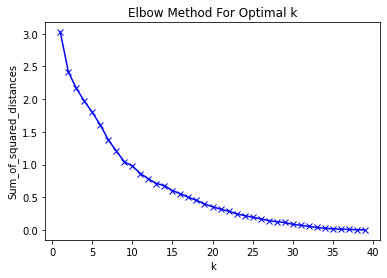

In [56]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Run k-Means clustering

Using the chosen number of clusters, I run k-Means clustering on the 39 neighbourhoods, and graph them using folium.

In [57]:
# set number of clusters
kclusters = 20

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([18,  1,  9, 10,  1, 13, 18,  1, 16, 12])

In [58]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_boroughs

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,18,Coffee Shop,Pub,Bakery,Park,Café,Breakfast Spot,Theater,Yoga Studio,French Restaurant,Health Food Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,18,Coffee Shop,Sushi Restaurant,Yoga Studio,Bank,Smoothie Shop,Beer Bar,Sandwich Place,Burrito Place,Café,Portuguese Restaurant
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,18,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Hotel,Middle Eastern Restaurant,Bubble Tea Shop,Cosmetics Shop,Lingerie Store,Ramen Restaurant
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,18,Coffee Shop,Café,Cocktail Bar,American Restaurant,Cosmetics Shop,Japanese Restaurant,Lingerie Store,Department Store,Creperie,Bakery
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Asian Restaurant,Pub,Health Food Store,Trail,Neighborhood,Dog Run,Dessert Shop,Diner,Discount Store,Distribution Center


In [59]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Observing clusters and final observations

When using a smaller number of clusters I noticed that the neighbourhoods would normally split into two clusters while leaving the remaining clusters as clusters of one neighbourhood. The same behaviour was observed when the number of clusters was increased to 20, although there were roughly three clusters with similar sizes.

For future work, I would explore other defining features other than popular venues that could potentially group neighbourhoods in a better way. Refining my search to a specific type of venue would potentially help as well.

Listed below are the individual clusters.


In [60]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M6J,West Toronto,"Little Portugal, Trinity",0,Bar,Men's Store,Café,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Asian Restaurant,Restaurant,Beer Store,Japanese Restaurant
69,M6P,West Toronto,"High Park, The Junction South",0,Café,Thai Restaurant,Mexican Restaurant,Cajun / Creole Restaurant,Arts & Crafts Store,Bar,Discount Store,Bakery,Diner,Speakeasy
80,M5S,Downtown Toronto,"University of Toronto, Harbord",0,Café,Bar,Italian Restaurant,Japanese Restaurant,Bookstore,Bakery,Yoga Studio,Beer Bar,Beer Store,Sandwich Place
84,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Mexican Restaurant,Vietnamese Restaurant,Dessert Shop,Caribbean Restaurant,Park,Bakery,Arts & Crafts Store


In [61]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,M5G,Downtown Toronto,Central Bay Street,1,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Bubble Tea Shop,Salad Place,Thai Restaurant,Burger Joint,Modern European Restaurant,Japanese Restaurant
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",1,Coffee Shop,Café,Restaurant,Hotel,Deli / Bodega,Gym,Thai Restaurant,Lounge,Steakhouse,Bakery
36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",1,Coffee Shop,Aquarium,Hotel,Café,Italian Restaurant,Brewery,Fried Chicken Joint,Restaurant,Scenic Lookout,History Museum
42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",1,Coffee Shop,Hotel,Café,Restaurant,Salad Place,Italian Restaurant,Seafood Restaurant,American Restaurant,Japanese Restaurant,Concert Hall
43,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",1,Café,Breakfast Spot,Coffee Shop,Furniture / Home Store,Office,Bar,Intersection,Bakery,Restaurant,Climbing Gym
48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",1,Coffee Shop,Restaurant,Café,Hotel,American Restaurant,Gym,Japanese Restaurant,Deli / Bodega,Italian Restaurant,Seafood Restaurant
97,M5X,Downtown Toronto,"First Canadian Place, Underground city",1,Coffee Shop,Café,Hotel,Restaurant,Japanese Restaurant,Gym,Steakhouse,American Restaurant,Seafood Restaurant,Salad Place


In [62]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,M4E,East Toronto,The Beaches,2,Asian Restaurant,Pub,Health Food Store,Trail,Neighborhood,Dog Run,Dessert Shop,Diner,Discount Store,Distribution Center


In [63]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,M4W,Downtown Toronto,Rosedale,3,Park,Playground,Trail,Department Store,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop


In [64]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,M5N,Central Toronto,Roselawn,4,Ice Cream Shop,Home Service,Music Venue,Garden,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Department Store


In [65]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,M4N,Central Toronto,Lawrence Park,5,Park,Construction & Landscaping,Bus Line,Swim School,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop


In [66]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
75,M6R,West Toronto,"Parkdale, Roncesvalles",6,Breakfast Spot,Gift Shop,Dessert Shop,Cuban Restaurant,Italian Restaurant,Bookstore,Movie Theater,Dog Run,Bar,Restaurant


In [67]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
83,M4T,Central Toronto,"Moore Park, Summerhill East",7,Gym,Park,Dessert Shop,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop


In [68]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 8, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",8,Trail,Jewelry Store,Mexican Restaurant,Sushi Restaurant,Yoga Studio,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant


In [69]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 9, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",9,Light Rail Station,Yoga Studio,Skate Park,Auto Workshop,Brewery,Burrito Place,Comic Shop,Farmers Market,Fast Food Restaurant,Garden


In [70]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 10, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
87,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",10,Airport Service,Airport Terminal,Airport Lounge,Boat or Ferry,Rental Car Location,Bar,Plane,Harbor / Marina,Sculpture Garden,Airport Gate


In [71]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 11, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
86,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",11,Coffee Shop,Fried Chicken Joint,Liquor Store,Restaurant,Bank,Bagel Shop,Pub,Supermarket,Light Rail Station,Athletics & Sports


In [72]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 12, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
67,M4P,Central Toronto,Davisville North,12,Hotel,Gym / Fitness Center,Food & Drink Shop,Park,Pizza Place,Breakfast Spot,Department Store,Sandwich Place,Diner,Discount Store


In [73]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 13, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,M6G,Downtown Toronto,Christie,13,Grocery Store,Café,Park,Coffee Shop,Italian Restaurant,Restaurant,Baby Store,Candy Store,Athletics & Sports,Nightclub


In [74]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 14, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,M6H,West Toronto,"Dufferin, Dovercourt Village",14,Bakery,Pharmacy,Park,Art Gallery,Café,Bar,Bank,Supermarket,Middle Eastern Restaurant,Portuguese Restaurant


In [75]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 15, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,M4K,East Toronto,"The Danforth West, Riverdale",15,Greek Restaurant,Italian Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Furniture / Home Store,Yoga Studio,Bakery,Indian Restaurant,Spa


In [76]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 16, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
74,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",16,Sandwich Place,Café,Coffee Shop,Park,BBQ Joint,Donut Shop,Burger Joint,Flower Shop,Middle Eastern Restaurant,Indian Restaurant
79,M4S,Central Toronto,Davisville,16,Dessert Shop,Sandwich Place,Italian Restaurant,Gym,Sushi Restaurant,Coffee Shop,Thai Restaurant,Pizza Place,Café,Pharmacy
81,M6S,West Toronto,"Runnymede, Swansea",16,Café,Coffee Shop,Sushi Restaurant,Italian Restaurant,Pub,Pizza Place,Dessert Shop,Smoothie Shop,Bookstore,Sandwich Place


In [77]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 17, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,M4L,East Toronto,"India Bazaar, The Beaches West",17,Sandwich Place,Fast Food Restaurant,Park,Sushi Restaurant,Liquor Store,Burrito Place,Restaurant,Italian Restaurant,Fish & Chips Shop,Steakhouse


In [78]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 18, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",18,Coffee Shop,Pub,Bakery,Park,Café,Breakfast Spot,Theater,Yoga Studio,French Restaurant,Health Food Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",18,Coffee Shop,Sushi Restaurant,Yoga Studio,Bank,Smoothie Shop,Beer Bar,Sandwich Place,Burrito Place,Café,Portuguese Restaurant
9,M5B,Downtown Toronto,"Garden District, Ryerson",18,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Hotel,Middle Eastern Restaurant,Bubble Tea Shop,Cosmetics Shop,Lingerie Store,Ramen Restaurant
15,M5C,Downtown Toronto,St. James Town,18,Coffee Shop,Café,Cocktail Bar,American Restaurant,Cosmetics Shop,Japanese Restaurant,Lingerie Store,Department Store,Creperie,Bakery
20,M5E,Downtown Toronto,Berczy Park,18,Coffee Shop,Cocktail Bar,Beer Bar,Farmers Market,Bakery,Seafood Restaurant,Restaurant,Pharmacy,Cheese Shop,Pub
54,M4M,East Toronto,Studio District,18,Coffee Shop,American Restaurant,Bakery,Brewery,Café,Gastropub,Yoga Studio,Fish Market,Park,Neighborhood
92,M5W,Downtown Toronto,Stn A PO Boxes,18,Coffee Shop,Seafood Restaurant,Restaurant,Beer Bar,Café,Cocktail Bar,Japanese Restaurant,Italian Restaurant,Bakery,Hotel
96,M4X,Downtown Toronto,"St. James Town, Cabbagetown",18,Coffee Shop,Pizza Place,Bakery,Café,Pub,Italian Restaurant,Restaurant,Bank,Bar,Market
99,M4Y,Downtown Toronto,Church and Wellesley,18,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Yoga Studio,Pub,Fast Food Restaurant,Men's Store,Mediterranean Restaurant


In [79]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 19, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
73,M4R,Central Toronto,"North Toronto West, Lawrence Park",19,Clothing Store,Coffee Shop,Yoga Studio,Sporting Goods Shop,Fast Food Restaurant,Diner,Mexican Restaurant,Pet Store,Chinese Restaurant,Café
